In [1]:
import sys
sys.path.append('../_amigocloud')

In [2]:
import simplekml

In [3]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
#from shapely.geometry import Point, MultiPoint
import os
#from fastkml import kml

In [4]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [7]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [5]:
os = 30

In [6]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_cat = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\catastro140624.shp'
path_puntos = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'

gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [7]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


In [9]:
# filtrar la semna de interes
gdf_puntos_sem = gdf_puntos[gdf_puntos['os'] == os]
gdf_puntos_sem

,unidad_03,unidad_04,os,dia,geometry
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,"MULTIPOINT (482079.520 8078995.241, 482466.745..."


In [10]:
multipoint_gdf = gdf_puntos_sem

In [11]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [12]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,dia,geometry
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (482079.520 8078995.241)
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (482466.745 8078306.443)
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (482236.921 8078712.838)
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (480653.381 8080932.597)
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (481014.933 8080425.304)


<Axes: >

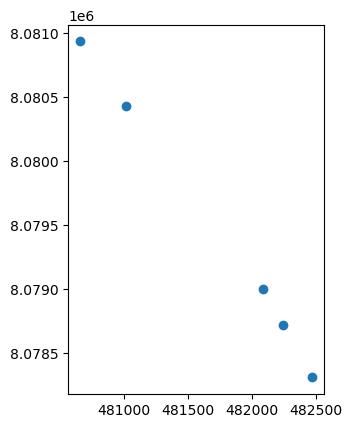

In [13]:
puntos_indi.plot()

In [14]:
# Asegurarse de que ambos GeoDataFrames tienen el mismo sistema de coordenadas (CRS)
if puntos_indi.crs != gdf_siembras.crs:
    print('Los CRS no son iguales')
    #gdf_siembras = gdf_siembras.to_crs(puntos_indi.crs)
else:
    print('Los CRS si son iguales')

Los CRS si son iguales


In [15]:
# Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono
puntos_indi_solicitado = puntos_indi[~puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]

In [16]:
puntos_indi_solicitado

,unidad_03,unidad_04,os,dia,geometry
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (482079.520 8078995.241)
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (482466.745 8078306.443)
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (480653.381 8080932.597)
4,2816,DONOSO BLANCO ALBERTO\r\n,30,0,POINT (481014.933 8080425.304)


In [17]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'geometry']]

In [18]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,geometry
12074,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,B2,15.93,123,"POLYGON ((481119.930 8080378.683, 480947.024 8..."
12905,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A4.1,2.12,123,"POLYGON ((482289.170 8078979.600, 482313.775 8..."
12906,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A11,2.89,123,"POLYGON ((482431.127 8078242.665, 482309.857 8..."
12907,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,B1.1,1.97,123,"POLYGON ((480712.080 8080887.638, 480656.325 8..."


In [19]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi_solicitado.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [20]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,geometry
12074,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B2,15.93,123,"POLYGON ((481119.930 8080378.683, 480947.024 8..."
12905,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A4.1,2.12,123,"POLYGON ((482289.170 8078979.600, 482313.775 8..."
12906,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A11,2.89,123,"POLYGON ((482431.127 8078242.665, 482309.857 8..."
12907,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B1.1,1.97,123,"POLYGON ((480712.080 8080887.638, 480656.325 8..."


In [22]:
poligonos_intersect_cat['fecha_ini'] = ''
poligonos_intersect_cat['origen'] = 'SOLICITUD'
poligonos_intersect_cat['dias'] = 0
poligonos_intersect_cat['fecha'] = ''
poligonos_intersect_cat['os'] = os

In [85]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,geometry,fecha_ini,origen,dias,fecha,os
12074,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B2,15.93,123,"POLYGON ((481119.930 8080378.683, 480947.024 8...",,SOLICITUD,0,,30
12905,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A4.1,2.12,123,"POLYGON ((482289.170 8078979.600, 482313.775 8...",,SOLICITUD,0,,30
12906,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A11,2.89,123,"POLYGON ((482431.127 8078242.665, 482309.857 8...",,SOLICITUD,0,,30
12907,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B1.1,1.97,123,"POLYGON ((480712.080 8080887.638, 480656.325 8...",,SOLICITUD,0,,30


In [24]:
# SELECCIONAR LOS LOTES DE SIEMBRAS
# identifoca los lotes que se intersectan
gdf_lotes_siem = gpd.sjoin(gdf_siembras, multipoint_gdf, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
# copy
poligonos_intersect_siem = poligonos_intersect_siem.copy()
# agregar campo de semana_planificacion
poligonos_intersect_siem['os'] = os

In [25]:
poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2023' in x else 0)

In [26]:
poligonos_intersect_siem

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,geometry,os,soca
85,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A5.3,3.257755,20/6/2024,SIEMBRA 2023,7,2024-06-20,4,"POLYGON ((482171.958 8078929.023, 482259.644 8...",30,1


In [27]:
# Concatenar los DataFrames a lo largo de las filas (axis=0)
plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)
# Si deseas restablecer el índice después de concatenar
plan.reset_index(drop=True, inplace=True)

<Axes: >

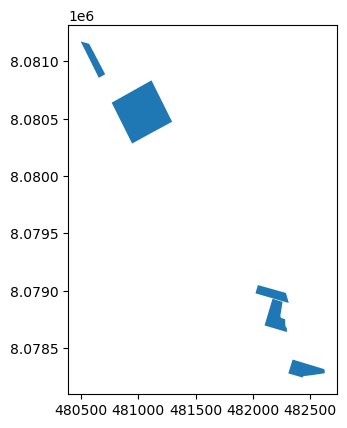

In [28]:
plan.plot()

In [29]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,geometry,fecha_ini,origen,dias,fecha,os,prioridad
0,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B2,15.930000,123,"POLYGON ((481119.930 8080378.683, 480947.024 8...",,SOLICITUD,0,,30,NaN
1,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A4.1,2.120000,123,"POLYGON ((482289.170 8078979.600, 482313.775 8...",,SOLICITUD,0,,30,NaN
2,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A11,2.890000,123,"POLYGON ((482431.127 8078242.665, 482309.857 8...",,SOLICITUD,0,,30,NaN
3,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B1.1,1.970000,123,"POLYGON ((480712.080 8080887.638, 480656.325 8...",,SOLICITUD,0,,30,NaN
4,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A5.3,3.257755,1,"POLYGON ((482171.958 8078929.023, 482259.644 8...",20/6/2024,SIEMBRA 2023,7,2024-06-20,30,4.0


In [80]:
# cargar el shp de planificacion existente
path_plan = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION_TEST.shp'
gdf_plan = gpd.read_file(path_plan)

In [81]:
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [82]:
last_id

0

In [83]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [84]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B2,15.930000,123,"POLYGON ((481119.930 8080378.683, 480947.024 8...",,SOLICITUD,0,,30,NaN,1
1,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A4.1,2.120000,123,"POLYGON ((482289.170 8078979.600, 482313.775 8...",,SOLICITUD,0,,30,NaN,2
2,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A11,2.890000,123,"POLYGON ((482431.127 8078242.665, 482309.857 8...",,SOLICITUD,0,,30,NaN,3
3,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B1.1,1.970000,123,"POLYGON ((480712.080 8080887.638, 480656.325 8...",,SOLICITUD,0,,30,NaN,4
4,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A5.3,3.257755,1,"POLYGON ((482171.958 8078929.023, 482259.644 8...",20/6/2024,SIEMBRA 2023,7,2024-06-20,30,4.0,5


In [85]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_23008\364328693.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)


In [86]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,os,soca,id,geometry
0,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B2,15.930000,,SOLICITUD,0,,NaN,30,123,1,"POLYGON ((481119.930 8080378.683, 480947.024 8..."
1,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A4.1,2.120000,,SOLICITUD,0,,NaN,30,123,2,"POLYGON ((482289.170 8078979.600, 482313.775 8..."
2,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,A11,2.890000,,SOLICITUD,0,,NaN,30,123,3,"POLYGON ((482431.127 8078242.665, 482309.857 8..."
3,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO\r\n,B1.1,1.970000,,SOLICITUD,0,,NaN,30,123,4,"POLYGON ((480712.080 8080887.638, 480656.325 8..."
4,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A5.3,3.257755,20/6/2024,SIEMBRA 2023,7,2024-06-20,4.0,30,1,5,"POLYGON ((482171.958 8078929.023, 482259.644 8..."


In [87]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)

In [88]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [140]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [141]:
# repreyectar a WGS84
plan = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
plan['geometry'] = plan['geometry'].apply(convertir_a_multipolygon)

In [35]:
#plan

In [142]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in plan.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (sem_reg, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, sem_plan, geometry)
    VALUES ({row['sem_reg']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['sem_plan']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR KMLS DE PLANIFICACION

In [143]:
path_kml = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN'

In [144]:
path_plan = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION.shp'
gdf_plan = gpd.read_file(path_plan)

In [145]:
gdf_plan_sem = gdf_plan[gdf_plan['sem_plan']==str(semana)]
gdf_plan_sem

,sem_reg,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,sem_plan,id,fecha,prioridad,geometry
87,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,L5.1,1.264498,None,SOLICITUD,0,32,None,None,0.0,"POLYGON ((468958.101 8096856.431, 468959.680 8..."
88,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,11.556979,None,SIEMBRA 2023,0,32,None,None,13.0,"POLYGON ((469150.275 8096553.954, 469423.512 8..."
89,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5.1,0.839625,None,SIEMBRA 2023,0,32,None,None,13.0,"POLYGON ((469093.386 8096705.068, 469059.765 8..."
90,25.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,2024-04-25,SIEMBRA 2024,63,32,None,2024-04-25,6.0,"POLYGON ((469569.170 8096038.910, 469570.955 8..."
91,25.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L3,2.902202,2024-04-29,SIEMBRA 2024,59,32,None,2024-04-29,13.0,"POLYGON ((469256.883 8096164.412, 469189.404 8..."


In [146]:
lista_cods = list(set(gdf_plan_sem['unidad_01']))

In [147]:
lista_cods

['369']

In [148]:
for i in lista_cods:
    prop = gdf_plan_sem[gdf_plan_sem['unidad_01'] == i]
    prop_wgs = prop.to_crs(epsg=4326)
    output_folder = path_kml + '\\' + i
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Recorrer el GeoDataFrame
    for idx, row in prop_wgs.iterrows():
        # Crear un nuevo documento KML
        kml_doc = simplekml.Kml()
        # Obtener el polígono y el nombre
        polygon = row['geometry']
        name = row['unidad_05']
        # Convertir el polígono en una lista de coordenadas
        coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]    
        # Añadir el polígono al documento KML
        pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
        # Guardar el archivo KML
        file_name = f"{name}.kml"
        output_path = os.path.join(output_folder, file_name)
        kml_doc.save(output_path)

# CREAR XLSX

In [120]:
path_plan_XLSX = f"G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S{semana}.xlsx"
path_plan_XLSX

'G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S23.xlsx'

In [123]:
poligonos_intersect.columns

Index(['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04',
       'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'geometry',
       'sem_plan'],
      dtype='object')

In [128]:
df_xlsx = poligonos_intersect[['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'sem_plan']]

In [129]:
df_xlsx.to_excel(path_plan_XLSX, index=False, engine='openpyxl')